# CIFAR-10 classification
## 1. Baseline
### 1.1.  import libraries and define hyperparameters

In [2]:
!pip -q install cleverhans
# !pip -q install linformer
!pip -q install ptflops
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip -q install vit_pytorch

     |████████████████████████████████| 327kB 10.9MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 163kB 24.3MB/s 


In [4]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
import matplotlib.pyplot as plt 
import numpy as np
import os 
from ptflops import get_model_complexity_info
import random
import torch
from torch import nn
from torchvision.models import resnet34, resnet101, mobilenet_v2
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from vit_pytorch import ViT

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [6]:
device = 'cuda'

### 1.2. load and normalize CIFAR-10

In [7]:
batch_size = 256

In [8]:
mean = [0.5, 0.5, 0.5]
std =  [0.5, 0.5, 0.5]
transform_train = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [9]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1.3. define a transformer

In [11]:
class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 32, 32)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 8, 8)
        return out

In [13]:
resnet_feature = ResNetFeatures().to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [47]:
model = ViT(
    image_size=8,
    patch_size=4,
    num_classes=10,
    dim = 512,
    depth = 12,
    heads = 16,
    channels=64,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

Let's see the parameter numbers and FLOPs of Hybrid ViT

In [17]:
macs, params = get_model_complexity_info(model, (64, 8, 8), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.16 GMac
Number of parameters:           32.03 M 


### 1.4. Let's start our training!

In [48]:
lr = 3e-5

In [49]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [50]:
loss_record = {'train': [], 'validation': []} 
acc_record = {'train': [], 'validation': []} 

In [51]:
def train(epochs, model, resnet_feature, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer, scheduler, adv_train=False):
    #optimizer.zero_grad()
    #optimizer.step()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        print("current lr = %lf"%optimizer.param_groups[0]['lr'])

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            with torch.no_grad():
                data = resnet_feature(data)
            if adv_train:
                # Replace clean example with adversarial example for adversarial training
                data = projected_gradient_descent(model, data, 0.3, 0.01, 40, np.inf)
            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        loss_record['train'].append(epoch_loss.detach().cpu().item())
        acc_record['train'].append(epoch_accuracy.detach().cpu().item())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)
                data = resnet_feature(data)
                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
            loss_record['validation'].append(epoch_val_loss.detach().cpu().item())
            acc_record['validation'].append(epoch_val_accuracy.detach().cpu().item())

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

In [ ]:
epochs = 100

In [52]:
train(epochs, model, resnet_feature, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer, scheduler)

current lr = 0.000030



Epoch : 1 - loss : 2.0142 - acc: 0.2382 - val_loss : 1.7789 - val_acc: 0.3339

current lr = 0.000030



Epoch : 2 - loss : 1.7386 - acc: 0.3527 - val_loss : 1.7077 - val_acc: 0.3685

current lr = 0.000030



Epoch : 3 - loss : 1.6541 - acc: 0.3908 - val_loss : 1.6181 - val_acc: 0.4068

current lr = 0.000030



Epoch : 4 - loss : 1.5955 - acc: 0.4199 - val_loss : 1.5755 - val_acc: 0.4167

current lr = 0.000030



Epoch : 5 - loss : 1.5627 - acc: 0.4334 - val_loss : 1.6083 - val_acc: 0.4167

current lr = 0.000030



Epoch : 6 - loss : 1.5358 - acc: 0.4452 - val_loss : 1.5243 - val_acc: 0.4508

current lr = 0.000030



Epoch : 7 - loss : 1.5027 - acc: 0.4587 - val_loss : 1.5011 - val_acc: 0.4599

current lr = 0.000030



Epoch : 8 - loss : 1.4854 - acc: 0.4659 - val_loss : 1.4744 - val_acc: 0.4680

current lr = 0.000030



Epoch : 9 - loss : 1.4686 - acc: 0.4716 - val_loss : 1.4909 - val_acc: 0.4782

current lr = 0.000030



Epoch : 10 - loss : 1.4501 - acc: 0.4790 - val_loss : 1.4664 - val_acc: 0.4654

current lr = 0.000030



Epoch : 11 - loss : 1.4315 - acc: 0.4855 - val_loss : 1.4548 - val_acc: 0.4731

current lr = 0.000030



Epoch : 12 - loss : 1.4180 - acc: 0.4879 - val_loss : 1.4789 - val_acc: 0.4779

current lr = 0.000030



Epoch : 13 - loss : 1.3906 - acc: 0.5039 - val_loss : 1.3731 - val_acc: 0.5062

current lr = 0.000030



Epoch : 14 - loss : 1.3772 - acc: 0.5086 - val_loss : 1.3773 - val_acc: 0.5077

current lr = 0.000030



Epoch : 15 - loss : 1.3647 - acc: 0.5129 - val_loss : 1.3560 - val_acc: 0.5132

current lr = 0.000030



Epoch : 16 - loss : 1.3389 - acc: 0.5213 - val_loss : 1.3645 - val_acc: 0.5105

current lr = 0.000030



Epoch : 17 - loss : 1.3263 - acc: 0.5240 - val_loss : 1.3655 - val_acc: 0.5162

current lr = 0.000030



Epoch : 18 - loss : 1.3000 - acc: 0.5354 - val_loss : 1.2957 - val_acc: 0.5376

current lr = 0.000030



Epoch : 19 - loss : 1.2823 - acc: 0.5426 - val_loss : 1.2924 - val_acc: 0.5443

current lr = 0.000030



Epoch : 20 - loss : 1.2651 - acc: 0.5491 - val_loss : 1.2674 - val_acc: 0.5409

current lr = 0.000030



Epoch : 21 - loss : 1.2463 - acc: 0.5558 - val_loss : 1.2756 - val_acc: 0.5428

current lr = 0.000030



Epoch : 22 - loss : 1.2324 - acc: 0.5602 - val_loss : 1.2515 - val_acc: 0.5521

current lr = 0.000030



Epoch : 23 - loss : 1.2200 - acc: 0.5659 - val_loss : 1.2294 - val_acc: 0.5679

current lr = 0.000030



Epoch : 24 - loss : 1.2167 - acc: 0.5675 - val_loss : 1.2071 - val_acc: 0.5672

current lr = 0.000030



Epoch : 25 - loss : 1.1873 - acc: 0.5768 - val_loss : 1.2143 - val_acc: 0.5740

current lr = 0.000030



Epoch : 26 - loss : 1.1819 - acc: 0.5792 - val_loss : 1.1927 - val_acc: 0.5760

current lr = 0.000030



Epoch : 27 - loss : 1.1564 - acc: 0.5913 - val_loss : 1.1869 - val_acc: 0.5796

current lr = 0.000030



Epoch : 28 - loss : 1.1476 - acc: 0.5934 - val_loss : 1.1841 - val_acc: 0.5825

current lr = 0.000030



Epoch : 29 - loss : 1.1428 - acc: 0.5940 - val_loss : 1.1387 - val_acc: 0.5970

current lr = 0.000030



Epoch : 30 - loss : 1.1345 - acc: 0.5984 - val_loss : 1.1420 - val_acc: 0.5953

current lr = 0.000030



Epoch : 31 - loss : 1.1138 - acc: 0.6034 - val_loss : 1.1525 - val_acc: 0.5962

current lr = 0.000030



Epoch : 32 - loss : 1.1101 - acc: 0.6057 - val_loss : 1.1388 - val_acc: 0.5916

current lr = 0.000030



Epoch : 33 - loss : 1.1017 - acc: 0.6102 - val_loss : 1.1134 - val_acc: 0.6033

current lr = 0.000030



Epoch : 34 - loss : 1.0890 - acc: 0.6133 - val_loss : 1.1263 - val_acc: 0.5928

current lr = 0.000030



Epoch : 35 - loss : 1.0787 - acc: 0.6191 - val_loss : 1.1048 - val_acc: 0.6125

current lr = 0.000030



Epoch : 36 - loss : 1.0711 - acc: 0.6246 - val_loss : 1.0734 - val_acc: 0.6164

current lr = 0.000030



Epoch : 37 - loss : 1.0691 - acc: 0.6194 - val_loss : 1.1004 - val_acc: 0.6168

current lr = 0.000030



Epoch : 38 - loss : 1.0563 - acc: 0.6268 - val_loss : 1.0938 - val_acc: 0.6147

current lr = 0.000030



Epoch : 39 - loss : 1.0406 - acc: 0.6308 - val_loss : 1.0682 - val_acc: 0.6170

current lr = 0.000030



Epoch : 40 - loss : 1.0502 - acc: 0.6280 - val_loss : 1.0863 - val_acc: 0.6176

current lr = 0.000030



Epoch : 41 - loss : 1.0334 - acc: 0.6370 - val_loss : 1.0456 - val_acc: 0.6319

current lr = 0.000030



Epoch : 42 - loss : 1.0189 - acc: 0.6388 - val_loss : 1.0694 - val_acc: 0.6230

current lr = 0.000030



Epoch : 43 - loss : 1.0209 - acc: 0.6398 - val_loss : 1.0456 - val_acc: 0.6254

current lr = 0.000030



Epoch : 44 - loss : 1.0094 - acc: 0.6434 - val_loss : 1.0211 - val_acc: 0.6381

current lr = 0.000030



Epoch : 45 - loss : 1.0085 - acc: 0.6442 - val_loss : 1.0666 - val_acc: 0.6264

current lr = 0.000030



Epoch : 46 - loss : 1.0003 - acc: 0.6487 - val_loss : 1.0083 - val_acc: 0.6464

current lr = 0.000030



Epoch : 47 - loss : 0.9876 - acc: 0.6515 - val_loss : 1.0146 - val_acc: 0.6402

current lr = 0.000030



Epoch : 48 - loss : 0.9837 - acc: 0.6540 - val_loss : 1.0019 - val_acc: 0.6459

current lr = 0.000030



Epoch : 49 - loss : 0.9758 - acc: 0.6558 - val_loss : 0.9962 - val_acc: 0.6436

current lr = 0.000030



Epoch : 50 - loss : 0.9605 - acc: 0.6625 - val_loss : 1.0178 - val_acc: 0.6419

current lr = 0.000030



Epoch : 51 - loss : 0.9578 - acc: 0.6626 - val_loss : 1.0080 - val_acc: 0.6433

current lr = 0.000030



Epoch : 52 - loss : 0.9562 - acc: 0.6658 - val_loss : 0.9976 - val_acc: 0.6516

current lr = 0.000030



Epoch : 53 - loss : 0.9380 - acc: 0.6708 - val_loss : 1.0098 - val_acc: 0.6351

current lr = 0.000030



Epoch : 54 - loss : 0.9436 - acc: 0.6689 - val_loss : 0.9623 - val_acc: 0.6662

current lr = 0.000030



Epoch : 55 - loss : 0.9383 - acc: 0.6695 - val_loss : 0.9805 - val_acc: 0.6564

current lr = 0.000030



Epoch : 56 - loss : 0.9283 - acc: 0.6739 - val_loss : 0.9816 - val_acc: 0.6481

current lr = 0.000030



Epoch : 57 - loss : 0.9323 - acc: 0.6735 - val_loss : 0.9663 - val_acc: 0.6577

current lr = 0.000030



Epoch : 58 - loss : 0.9202 - acc: 0.6763 - val_loss : 0.9606 - val_acc: 0.6546

current lr = 0.000030



Epoch : 59 - loss : 0.9131 - acc: 0.6766 - val_loss : 0.9667 - val_acc: 0.6699

current lr = 0.000030



Epoch : 60 - loss : 0.9087 - acc: 0.6799 - val_loss : 0.9620 - val_acc: 0.6597

current lr = 0.000030



Epoch : 61 - loss : 0.9010 - acc: 0.6830 - val_loss : 0.9644 - val_acc: 0.6596

current lr = 0.000030



Epoch : 62 - loss : 0.8943 - acc: 0.6874 - val_loss : 0.9474 - val_acc: 0.6635

current lr = 0.000030



Epoch : 63 - loss : 0.8952 - acc: 0.6848 - val_loss : 0.9362 - val_acc: 0.6676

current lr = 0.000030



Epoch : 64 - loss : 0.8870 - acc: 0.6882 - val_loss : 0.9406 - val_acc: 0.6715

current lr = 0.000030



Epoch : 65 - loss : 0.8859 - acc: 0.6864 - val_loss : 0.9424 - val_acc: 0.6721

current lr = 0.000030



Epoch : 66 - loss : 0.8745 - acc: 0.6921 - val_loss : 0.9396 - val_acc: 0.6723

current lr = 0.000030



Epoch : 67 - loss : 0.8724 - acc: 0.6937 - val_loss : 0.9177 - val_acc: 0.6715

current lr = 0.000030



Epoch : 68 - loss : 0.8656 - acc: 0.6965 - val_loss : 0.9135 - val_acc: 0.6779

current lr = 0.000030



Epoch : 69 - loss : 0.8610 - acc: 0.6969 - val_loss : 0.9270 - val_acc: 0.6740

current lr = 0.000030



Epoch : 70 - loss : 0.8600 - acc: 0.6965 - val_loss : 0.9252 - val_acc: 0.6722

current lr = 0.000030



Epoch : 71 - loss : 0.8543 - acc: 0.6992 - val_loss : 0.9046 - val_acc: 0.6815

current lr = 0.000030



Epoch : 72 - loss : 0.8466 - acc: 0.7026 - val_loss : 0.9354 - val_acc: 0.6733

current lr = 0.000030



Epoch : 73 - loss : 0.8429 - acc: 0.7058 - val_loss : 0.8987 - val_acc: 0.6895

current lr = 0.000030



Epoch : 74 - loss : 0.8444 - acc: 0.7040 - val_loss : 0.9014 - val_acc: 0.6792

current lr = 0.000030



Epoch : 75 - loss : 0.8343 - acc: 0.7080 - val_loss : 0.9203 - val_acc: 0.6792

current lr = 0.000030



Epoch : 76 - loss : 0.8269 - acc: 0.7089 - val_loss : 0.9034 - val_acc: 0.6818

current lr = 0.000030



Epoch : 77 - loss : 0.8210 - acc: 0.7133 - val_loss : 0.8876 - val_acc: 0.6888

current lr = 0.000030



Epoch : 78 - loss : 0.8242 - acc: 0.7115 - val_loss : 0.8717 - val_acc: 0.6908

current lr = 0.000030



Epoch : 79 - loss : 0.8187 - acc: 0.7110 - val_loss : 0.9034 - val_acc: 0.6929

current lr = 0.000030



Epoch : 80 - loss : 0.8151 - acc: 0.7146 - val_loss : 0.8853 - val_acc: 0.6913

current lr = 0.000030



Epoch : 81 - loss : 0.8140 - acc: 0.7143 - val_loss : 0.8906 - val_acc: 0.6912

current lr = 0.000030



Epoch : 82 - loss : 0.8055 - acc: 0.7175 - val_loss : 0.8802 - val_acc: 0.6945

current lr = 0.000030



Epoch : 83 - loss : 0.8004 - acc: 0.7181 - val_loss : 0.8758 - val_acc: 0.6894

current lr = 0.000030



Epoch : 84 - loss : 0.7935 - acc: 0.7226 - val_loss : 0.8707 - val_acc: 0.6887

current lr = 0.000030



Epoch : 85 - loss : 0.7884 - acc: 0.7235 - val_loss : 0.8744 - val_acc: 0.6915

current lr = 0.000030



Epoch : 86 - loss : 0.7840 - acc: 0.7251 - val_loss : 0.8858 - val_acc: 0.6881

current lr = 0.000030



Epoch : 87 - loss : 0.7863 - acc: 0.7236 - val_loss : 0.8816 - val_acc: 0.6885

current lr = 0.000030



Epoch : 88 - loss : 0.7794 - acc: 0.7285 - val_loss : 0.8661 - val_acc: 0.7013

current lr = 0.000030



Epoch : 89 - loss : 0.7797 - acc: 0.7249 - val_loss : 0.8589 - val_acc: 0.6990

current lr = 0.000030



Epoch : 90 - loss : 0.7734 - acc: 0.7295 - val_loss : 0.8593 - val_acc: 0.6919

current lr = 0.000030



Epoch : 91 - loss : 0.7668 - acc: 0.7315 - val_loss : 0.8430 - val_acc: 0.7099

current lr = 0.000030



Epoch : 92 - loss : 0.7686 - acc: 0.7292 - val_loss : 0.8803 - val_acc: 0.6986

current lr = 0.000030



Epoch : 93 - loss : 0.7573 - acc: 0.7335 - val_loss : 0.8585 - val_acc: 0.6966

current lr = 0.000030



Epoch : 94 - loss : 0.7586 - acc: 0.7314 - val_loss : 0.8366 - val_acc: 0.7054

current lr = 0.000030



Epoch : 95 - loss : 0.7622 - acc: 0.7327 - val_loss : 0.8493 - val_acc: 0.7070

current lr = 0.000030



Epoch : 96 - loss : 0.7517 - acc: 0.7363 - val_loss : 0.8363 - val_acc: 0.7088

current lr = 0.000030



Epoch : 97 - loss : 0.7530 - acc: 0.7340 - val_loss : 0.8569 - val_acc: 0.7084

current lr = 0.000030



Epoch : 98 - loss : 0.7481 - acc: 0.7366 - val_loss : 0.8537 - val_acc: 0.7086

current lr = 0.000030



Epoch : 99 - loss : 0.7475 - acc: 0.7372 - val_loss : 0.8647 - val_acc: 0.6969

current lr = 0.000030



Epoch : 100 - loss : 0.7467 - acc: 0.7365 - val_loss : 0.8622 - val_acc: 0.6928



In [60]:
def plot_loss_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.5,2.1)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_acc_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.2,0.8)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Accurary curve of {}'.format(title))
    plt.legend()
    plt.show()


In [62]:
%matplotlib notebook

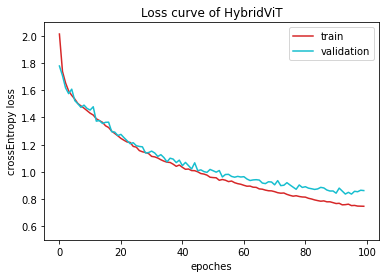

In [63]:
plot_loss_curve(loss_record, title='HybridViT')

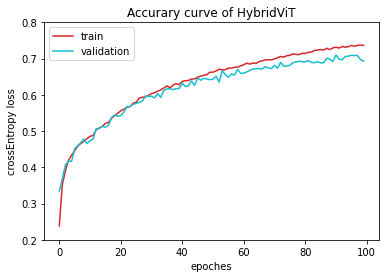

In [64]:
plot_acc_curve(acc_record, title='HybridViT')

In [45]:
def test(model, model_name, test_loader):
    correct = 0
    correct_fgm = 0
    correct_pgd = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        images = resnet_feature(images)
        images_fgm = fast_gradient_method(model, images, 0.3, np.inf)
        images_pgd = projected_gradient_descent(model, images, 0.3, 0.01, 40, np.inf)
        # calculate outputs by running images through the network
        outputs = model(images)
        outputs_fgm = model(images_fgm)
        outputs_pgd = model(images_pgd)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        _, predicted_fgm = torch.max(outputs_fgm.data, 1)
        _, predicted_pgd = torch.max(outputs_pgd.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_fgm += (predicted_fgm == labels).sum().item()
        correct_pgd += (predicted_pgd == labels).sum().item()

    print('Accuracy of the %s on the 10000 test images: %d %%' % (model_name,
        100 * correct / total))
    print('Accuracy of the %s on the 10000 FGM adversarial images: %d %%' % (model_name,
        100 * correct / total))
    print('Accuracy of the %s on the 10000 PFD adversarial images: %d %%' % (model_name,
        100 * correct / total))

In [46]:
test(model, 'HybridViT', test_loader)

Accuracy of the HybridViT on the 10000 test images: 56 %
Accuracy of the HybridViT on the 10000 FGM adversarial images: 56 %
Accuracy of the HybridViT on the 10000 PFD adversarial images: 56 %


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
np.save('/content/drive/MyDrive/loss_record_1.npy',loss_record)
np.save('/content/drive/MyDrive/acc_record_1.npy',acc_record)

In [54]:
PATH = '/content/drive/MyDrive/HybridViT_1.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
#model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 2. Experienment 1: MobileNet-v2

In [ ]:
from torchvision.models import mobilenet_v3_small

In [ ]:
mobileNet = mobilenet_v3_small(num_classes=10).to(device)

In [ ]:
macs, params = get_model_complexity_info(mobileNet, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.0 GMac
Number of parameters:           1.53 M  


In [ ]:
mobilenet_loss_record = {'train': [], 'validation': []} 
mobilenet_acc_record = {'train': [], 'validation': []} 

In [ ]:
mobilenet_opt = torch.optim.Adam(mobilenet.parameters(), lr=lr)
mobilenet_epochs = epochs

In [ ]:
train(epochs, mobileNet, train_loader, valid_loader, mobilenet_loss_record, mobilenet_acc_record, criterion, mobilenet_opt)

current lr = 0.000300



Epoch : 1 - loss : 2.3349 - acc: 0.1002 - val_loss : 2.3324 - val_acc: 0.0961

current lr = 0.000300



Epoch : 2 - loss : 2.3324 - acc: 0.1032 - val_loss : 2.3327 - val_acc: 0.0934

current lr = 0.000300



Epoch : 3 - loss : 2.3352 - acc: 0.0991 - val_loss : 2.3290 - val_acc: 0.0947

current lr = 0.000300



Epoch : 4 - loss : 2.3328 - acc: 0.1017 - val_loss : 2.3304 - val_acc: 0.1048

current lr = 0.000300



Epoch : 5 - loss : 2.3337 - acc: 0.1010 - val_loss : 2.3308 - val_acc: 0.1034



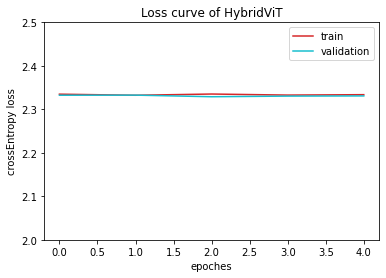

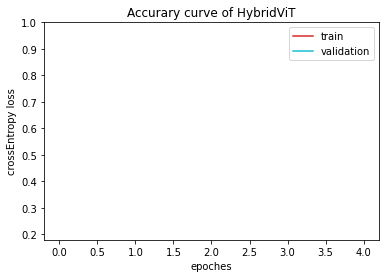

In [ ]:
plot_loss_curve(mobilenet_loss_record, title='HybridViT')
plot_acc_curve(mobilenet_acc_record, title='HybridViT')

In [ ]:
test(mobileNet,'MobileNet_v2', test_loader)

SyntaxError: ignored

comparison

In [ ]:
def loss_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.ylim(0,5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

def acc_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.ylim(0,1)
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('accuracy comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

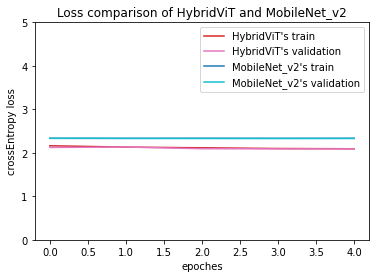

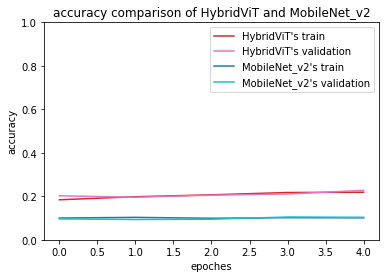

In [ ]:
loss_comparison_of_two(loss_record, mobilenet_loss_record, 'HybridViT', 'MobileNet_v2')
acc_comparison_of_two(acc_record, mobilenet_acc_record, 'HybridViT', 'MobileNet_v2')

In [ ]:
PATH = './mobilenet.pth'
torch.save(mobilenet.state_dict(), PATH)

## 3. experiment 2: model with similar FLOPs

In [ ]:
resnet = resnet101(num_classes=10)

In [ ]:
macs, params = get_model_complexity_info(resnet, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.16 GMac
Number of parameters:           42.52 M 


In [ ]:
resnet_loss_record = {'train': [], 'validation': []} 
resnet_acc_record = {'train': [], 'validation': []} 

In [ ]:
resnet_opt = torch.optim.Adam(resnet.parameters(), lr=lr)
resnet_epochs=epochs

In [ ]:
train(resnet_epochs, resnet, train_loader, valid_loader, resnet_loss_record, resnet_acc_record, criterion, resnet_opt)

In [ ]:
test(resnet, 'ResNet152',test_loader)

In [ ]:
loss_comparison_of_two(loss_record, resnet_loss_record)
acc_comparison_of_two(acc_record, resnet_acc_record)

In [ ]:
def loss_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))

    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:yellow', label=model_name_3+'\'s validation')
    plt.ylim(0.5,1.5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def acc_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:yellow', label=model_name_3+'\'s validation')
    plt.ylim(0.5,1.5)
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('acc curve of {}'.format(title))
    plt.legend()
    plt.show()

In [ ]:
loss_comparison_of_three(loss_record, mobilenet_loss_record, resnet_loss_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
acc_comparison_of_three(acc_record, mobilenet_acc_record, resnet_acc_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
PATH = './resnet.pth'
torch.save(resnet.state_dict(), PATH)

## 4. experiment 3. model robust

In [ ]:
adv_epochs=50
adv_mobilenet_epochs=50
adv_resnet_epochs=50

In [ ]:
adv_loss_record={'train': [], 'validation': []} 
adv_acc_record={'train': [], 'validation': []} 
adv_mobilenet_loss_record={'train': [], 'validation': []} 
adv_mobilenet_acc_record={'train': [], 'validation': []} 
adv_resnet_loss_record={'train': [], 'validation': []} 
adv_resnet_acc_record={'train': [], 'validation': []} 

In [ ]:
train(adv_epochs, model, train_loader, valid_loader, adv_loss_record, adv_acc_record, criterion, optimizer, adv_train=True)
train(adv_mobilenet_epochs, mobilenet, train_loader, valid_loader, adv_mobilenet_loss_record, adv_mobilenet_acc_record, criterion, mobilenet_optimizer,adv_train=True)
train(adv_resnet_epochs, resnet, train_loader, valid_loader, adv_resnet_loss_record, adv_resnet_acc_record, criterion, resnet_optimizer,adv_train=True)

In [ ]:
loss_comparison_of_three(adv_loss_record, adv_mobilenet_loss_record, adv_resnet_loss_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
acc_comparison_of_three(adv_acc_record, adv_mobilenet_acc_record, adv_resnet_acc_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
test(model, 'robust HybridViT', test_loader)
test(mobileNet, ,'robust MobileNet_v2', test_loader)
test(resnet, 'ResNet152', test_loader)

In [ ]:
PATH = './adv_HybridViT.pth'
torch.save(model.state_dict(), PATH)
PATH = './adv_Mobilenet.pth'
torch.save(mobilenet.state_dict(), PATH)
PATH = './adv_resnet.pth'
torch.save(resnet.state_dict(), PATH)